In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pysgpp import RegressionLearner, RegularGridConfiguration, \
AdpativityConfiguration, SLESolverConfiguration, RegularizationConfiguration, DataMatrix, \
DataVector
import numpy as np
import sklearn.preprocessing as pre
import sklearn.base
import sklearn.datasets
import sklearn.grid_search
from sklearn.cross_validation import ShuffleSplit

sns.set_style("darkgrid")
sns.set_palette("muted")

In [2]:
(X,Y) = sklearn.datasets.make_friedman3(n_samples=1500,noise=1.0, random_state=42)

In [3]:
scaler = pre.MinMaxScaler()
X = scaler.fit_transform(X)

In [4]:
def to_data_matrix(arr):
    (size_x, size_y) = arr.shape
    matrix = DataMatrix(size_x, size_y)
    cur_row = 0
    for x in arr:
        x_vec = DataVector(x.tolist())
        matrix.setRow(cur_row,x_vec)
        cur_row += 1
    return matrix      
        
# http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator
class SGRegressionLearner(sklearn.base.BaseEstimator, sklearn.base.RegressorMixin):
    def __init__(self, lambdaReg=0.01, T = 0.0, typeReg=2):
        self.lambdaReg = lambdaReg      
        self.typeReg = typeReg
        self.T = T
            
    def fit(self, X, y):        
        grid_config = RegularGridConfiguration()
        grid_config.dim_ = X.shape[1]
        grid_config.level_ = 3
        grid_config.type_ = 6 #ModLinear
        grid_config.t_ = self.T

        adaptivity_config = AdpativityConfiguration()
        adaptivity_config.noPoints_ = 0
        adaptivity_config.numRefinements_ = 0

        solver_config = SLESolverConfiguration()
        solver_config.type_ = 0 # CG
        solver_config.maxIterations_ = 500
        solver_config.eps_ = 1e-6

        regularization_config = RegularizationConfiguration()
        regularization_config.exponentBase_ = 0.25
        regularization_config.regType_ = self.typeReg # diagonal = 2
        regularization_config.lambda_ = self.lambdaReg
        self._learner = RegressionLearner(grid_config, adaptivity_config, solver_config, regularization_config)
                
        X_mat = to_data_matrix(X)
        y_vec = DataVector(y.tolist())
        self._learner.train(X_mat, y_vec)
            
    def predict(self, X):
        X_mat = to_data_matrix(X)
        result = self._learner.predict(X_mat)
        return result.array()
    
    def score(self, X, y, sample_weight=None):
        X_mat = to_data_matrix(X)
        y_vec = DataVector(y.tolist())
        mse = self._learner.getMSE(X_mat, y_vec)
        return -mse
    
    def getGridSize(self):
        return self._learner.getGridSize()

In [5]:
def plotGridSearch(gridSearch, T=0.0):
    scores = gridSearch.grid_scores_
    diag_scores = [s for s in scores if s[0]['typeReg'] == 2]
    ident_scores = [s for s in scores if s[0]['typeReg'] == 0]
    diag_params,diag_mean, diag_std = zip(*diag_scores)
    ident_params, ident_mean, ident_std = zip(*ident_scores)
    diag_mean = np.sqrt([-x for x in diag_mean])
    ident_mean = np.sqrt([-x for x in ident_mean])
    lambdas = [l['lambdaReg'] for l in diag_params]
    diff_mean = diag_mean - ident_mean
    
    fig = plt.figure(2, figsize=(15,5))

    ax1 = fig.add_subplot(121)
    ax1.set_xlabel("RMSE")
    ax1.set_ylabel("Lambda")
    ax1.plot(lambdas, diag_mean)
    ax1.plot(lambdas, ident_mean)
    ax1.legend(["Diagonal", "Identity"])
    ax1.set_xscale('log')
    ax1.invert_xaxis()
    ax1.set_title("RMSE for T = " + str(T))

    ax2 = fig.add_subplot(122)
    ax2.plot(lambdas, diff_mean)
    ax2.set_xlabel("RMSE difference")
    ax2.set_ylabel("Lambda")
    ax2.legend(["diag - ident"])
    ax2.set_xscale('log')
    ax2.invert_xaxis()
    ax2.set_title("No. of gridpoints " + str(gridSearch.best_estimator_.getGridSize()))

    fig.show()
    
def autoGridSearchWithT(X, Y, parameters, lambdaGrid, T=0.0):
    learner = SGRegressionLearner(T=T)
    cv = ShuffleSplit(X.shape[0], n_iter=5, random_state=42)
    parameters = [{"lambdaReg": lambdaGrid, "typeReg": [2]}, # diag
                  {"lambdaReg": lambdaGrid, "typeReg": [0]}] # ident
    gridSearch = sklearn.grid_search.GridSearchCV(learner, parameters, cv=cv, verbose=1, n_jobs=4)
    gridSearch.fit(X,Y)
    plotGridSearch(gridSearch, T)
    return gridSearch

In [13]:
lambdaGrid = np.logspace(1, -4, num=10)
parameters = [{"lambdaReg": lambdaGrid, "typeReg": [2]}, # diag
              {"lambdaReg": lambdaGrid, "typeReg": [0]}] # ident

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  94 out of 100 | elapsed:    5.0s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  94 out of 100 | elapsed:    5.0s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.4s finished


GridSearchCV(cv=ShuffleSplit(1500, n_iter=5, test_size=0.1, random_state=42),
       error_score='raise',
       estimator=SGRegressionLearner(T=0.0, lambdaReg=0.01, typeReg=2),
       fit_params={}, iid=True, loss_func=None, n_jobs=4,
       param_grid=[{'typeReg': [2], 'lambdaReg': array([  1.00000e+01,   2.78256e+00,   7.74264e-01,   2.15443e-01,
         5.99484e-02,   1.66810e-02,   4.64159e-03,   1.29155e-03,
         3.59381e-04,   1.00000e-04])}, {'typeReg': [0], 'lambdaReg': array([  1.00000e+01,   2.78256e+00,   7.74264e-01,   2.15443e-01,
         5.99484e-02,   1.66810e-02,   4.64159e-03,   1.29155e-03,
         3.59381e-04,   1.00000e-04])}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

GridSearchCV(cv=ShuffleSplit(1500, n_iter=5, test_size=0.1, random_state=42),
       error_score='raise',
       estimator=SGRegressionLearner(T=0.0, lambdaReg=0.01, typeReg=2),
       fit_params={}, iid=True, loss_func=None, n_jobs=4,
       param_grid=[{'typeReg': [2], 'lambdaReg': array([  1.00000e+01,   2.78256e+00,   7.74264e-01,   2.15443e-01,
         5.99484e-02,   1.66810e-02,   4.64159e-03,   1.29155e-03,
         3.59381e-04,   1.00000e-04])}, {'typeReg': [0], 'lambdaReg': array([  1.00000e+01,   2.78256e+00,   7.74264e-01,   2.15443e-01,
         5.99484e-02,   1.66810e-02,   4.64159e-03,   1.29155e-03,
         3.59381e-04,   1.00000e-04])}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

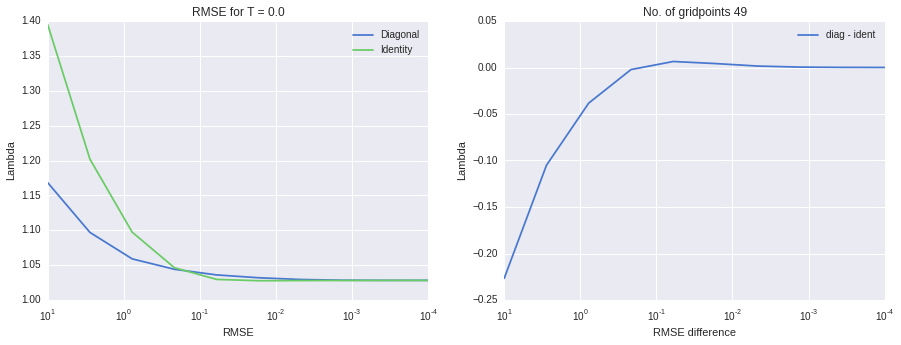

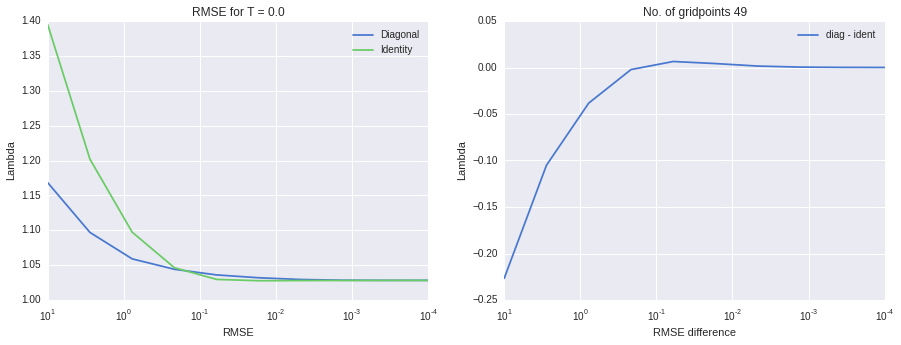

In [14]:
autoGridSearchWithT(X, Y, parameters, lambdaGrid, 0.0)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished


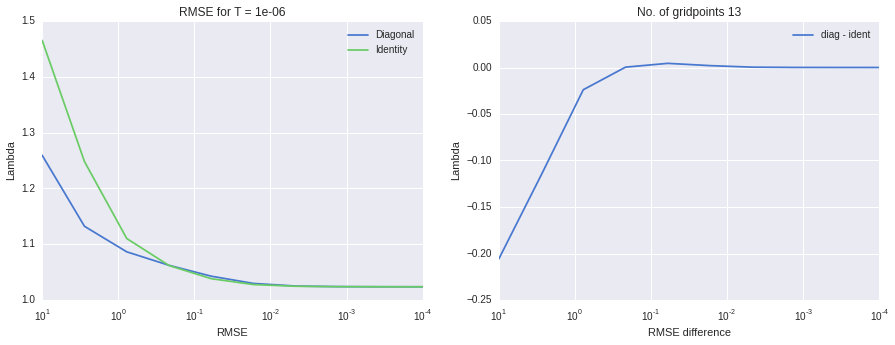

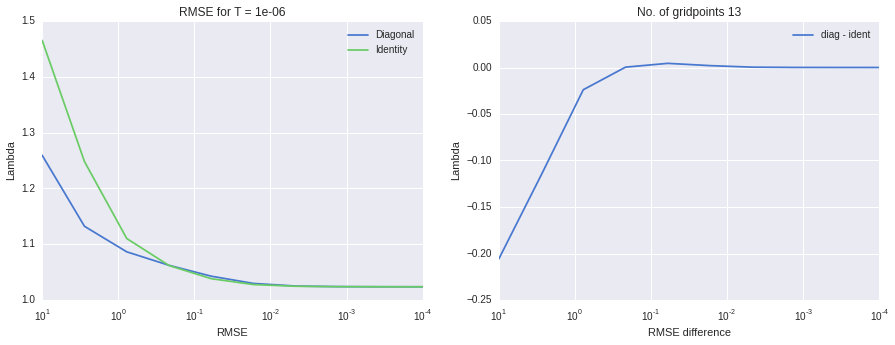

In [10]:
res = autoGridSearchWithT(X, Y, parameters, lambdaGrid, 0.000001)

In [ ]:
res.best_estimator_._learner.getGridSize()

In [2]:
import pysgpp
for t in xrange(0, 5):
    grid = pysgpp.Grid.createModLinearGrid(4)
    gen = grid.getGenerator()
    T = t*1.0 / 1000000000000
    gen.regular(3,T)
    print str(T) + "\t" + str(grid.getStorage().getSize())

0.0	49
1e-12	25
2e-12	25
3e-12	25
4e-12	25
0.0	49
1e-12	25
2e-12	25
3e-12	25
4e-12	25


In [2]:
import pysgpp
def getGridSize(d,l,T):
    grid = pysgpp.Grid.createModLinearGrid(d)
    gen = grid.getGenerator()
    gen.regular(l,T)
    print str(T) + "\t" + str(grid.getStorage().getSize())    

In [24]:
getGridSize(2,3,0)
getGridSize(2,3,1e-10)

0	17
1e-10	10
